# Exercise 5.1


In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

**Simple Network**

We continue with the dataset first encountered in the previous exercise. Please refer to the discussion there for an introduction to the data and the learning objective.

Here, we manually implement a simple network architecture

In [2]:
# The code snippet below is responsible for downloading the dataset
# - for example when running via Google Colab.
#
# You can also directly download the file using the link if you work
# with a local setup (the !wget command will work either way assuming
# you are on a unix-based machine and have wget installed)
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

File ‘winequality-white.csv’ already there; not retrieving.



In [3]:
# Before working with the data,
# we download and prepare all features

# load all examples from the file
data = np.genfromtxt("winequality-white.csv", delimiter=";", skip_header=1)

print(f"{data.shape = }")

# Prepare for proper training
rng = np.random.default_rng(1234)
rng.shuffle(data)  # randomly sort examples

mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
print("Mean shape: ",mean.shape)
# normalize
data = (data-mean)/std

# take the first 3000 examples for training
# (remember array slicing from last week)
X_train = data[:3000, :11]  # all features except last column
y_train = data[:3000, 11]  # quality column

# and the remaining examples for testing
X_test = data[3000:, :11]  # all features except last column
y_test = data[3000:, 11]  # quality column

print("First example:")
print("Features:", X_train[0])
print("Quality:", y_train[0])

data.shape = (4898, 12)
Mean shape:  (12,)
First example:
Features: [-0.06493106 -0.87554465  3.10566411  2.19037712 -0.17268156 -0.84138474
 -0.57327657  1.27486842 -2.24039624  0.08897337 -0.82427568]
Quality: 0.13787014016904103


# Problems

The goal is to implement the training of a neural network with one input layer, one hidden layer, and one output layer using gradient descent. We first (below) define the matrices and initialise with random values. We need W, b, W' and b'. The shapes will be:
  * W: (number of hidden nodes, number of inputs) named `W`
  * b: (number of hidden nodes) named `b`
  * W': (number of hidden nodes) named `Wp`
  * b': (one) named `bp`

Your tasks are:     
   * Implement a forward pass of the network as `dnn` (see below)
   * Implement a function that uses one data point to update the weights using gradient descent. You can follow the `update_weights` skeleton below
   * Now you can use the code below (training loop and evaluation) to train the network for multiple data points and even over several epochs. Try to find a set of hyperparameters (number of nodes in the hidden layer, learning rate, number of training epochs) that gives stable results. What is the best result (as measured by the loss on the training sample) you can get?

In [4]:
# Initialise weights with suitable random distributions
hidden_nodes = 50  # number of nodes in the hidden layer
n_inputs = 11  # input features in the dataset

W = rng.standard_normal(size=(hidden_nodes, 11)) * np.sqrt(2.0 / n_inputs)
b = rng.standard_normal(size=hidden_nodes) * np.sqrt(2.0 / n_inputs)
Wp = rng.standard_normal(size=hidden_nodes) * np.sqrt(2.0 / hidden_nodes)
bp = rng.standard_normal(size=(1))

print(f"{W.shape = }")
print(f"{b.shape = }")
print(f"{Wp.shape = }")
print(f"{bp.shape = }")

W.shape = (50, 11)
b.shape = (50,)
Wp.shape = (50,)
bp.shape = (1,)


In [5]:
# You can use this implementation of the ReLu activation function
def relu(x: np.ndarray) -> np.ndarray:
    """Simple implementation of a rectified linear unit.

    Parameters
    ----------
    x : array_like
        Array of input features.

    Returns
    -------
    np.ndarray
        Array containig function values of the relu for
        each element of the input array.
    """

    return np.maximum(x, 0)

In [6]:
def dnn(
    x: np.ndarray,
    W: np.ndarray,
    b: np.ndarray,
    Wp: np.ndarray,
    bp: np.ndarray,
) -> np.ndarray:
    """Simple DNN.

    Parameters
    ----------
    x : array_like
        Array of input features.
    W : array_like
        Array of input layer weights.
    b : array_like
        Array of input layer biases.
    Wp : array__like
        Array of output layer weighs.
    bp : array_like
        Array of output layer biases

    Returns
    -------
    np.ndarray, shape (1,)
        Array containing the float output of the DNN.
    """
    sigma = W @ x + b

    return Wp @ relu(sigma) + bp

In [8]:
def update_weights(
    x: np.ndarray,
    y: np.ndarray,
    W: np.ndarray,
    b: np.ndarray,
    Wp: np.ndarray,
    bp: np.ndarray,
    learning_rate = 0.0001
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Updates weights for given inputs, targets,
    weights, and biases.

    Parameters
    ----------
    x : array_like
        Array of input features.
    y : array_like
        Array of target features.
    W : array_like
        Array of input layer weights.
    b : array_like
        Array of input layer biases.
    Wp : array_like
        Array of output layer weighs.
    bp : array_like
        Array of output layer biases
    learning_rate : float
        Value of learning rate, default of 0.01, should be between 10-5 to 0.01
    Returns
    -------
    tuple
        Tuple of updated weight and bias arrays.
    """
    error = dnn(x, W, b, Wp, bp) - y
    Sum = W @ x + b
    pdL_pdbp = 2 * error
    pdL_pdbk = pdL_pdbp * Wp * np.heaviside(Sum,0)
    pdL_pdWpk = pdL_pdbp * relu(Sum)
    pdL_pdWmk = np.outer((pdL_pdbp * Wp * np.heaviside(Sum,0)), x)

    W_new = W - learning_rate * pdL_pdWmk
    b_new = b - learning_rate * pdL_pdbk
    Wp_new = Wp - learning_rate * pdL_pdWpk
    bp_new = bp - learning_rate * pdL_pdbp

    return W_new, b_new, Wp_new, bp_new # return the new weights

# Training loop and evaluation below

In [9]:
# The code below implements the training.
# If you correctly implement  dnn and update_weights above,
# you should not need to change anything below.
# (apart from increasing the number of epochs)

train_losses = []
test_losses = []

# How many epochs to train
# This will just train for one epoch
# You will want a higher number once everything works
n_epochs = 100

# Loop over the epochs
for ep in range(n_epochs):
    # Each epoch is a complete over the training data
    for i in range(X_train.shape[0]):
        # pick one example
        x = X_train[i]
        y = y_train[i]

        # use it to update the weights
        W, b, Wp, bp = update_weights(x, y, W, b, Wp, bp)#, learning_rate = 0.0001)

    # Calculate predictions for the full training and testing sample
    y_pred_train = [dnn(x, W, b, Wp, bp)[0] for x in X_train]
    y_pred = [dnn(x, W, b, Wp, bp)[0] for x in X_test]

    # Calculate aver loss / example over the epoch
    train_loss = np.sum((y_pred_train - y_train) ** 2) / y_train.shape[0]
    test_loss = np.sum((y_pred - y_test) ** 2) / y_test.shape[0]

    # print some information
    print("Epoch:", ep, "Train Loss:", train_loss, "Test Loss:", test_loss)

    # and store the losses for later use
    train_losses.append(train_loss)
    test_losses.append(test_loss)

Epoch: 0 Train Loss: 1.0281198640581195 Test Loss: 1.0277965452964057
Epoch: 1 Train Loss: 0.914192929161275 Test Loss: 0.9265616349435901
Epoch: 2 Train Loss: 0.8599852642202584 Test Loss: 0.8711058488386507
Epoch: 3 Train Loss: 0.822719329823919 Test Loss: 0.8305169930696658
Epoch: 4 Train Loss: 0.7946861072476799 Test Loss: 0.7997374426866689
Epoch: 5 Train Loss: 0.7726278624193791 Test Loss: 0.7758216292599822
Epoch: 6 Train Loss: 0.7549110275189586 Test Loss: 0.7568035009748857
Epoch: 7 Train Loss: 0.7402603805487112 Test Loss: 0.7413487427740828
Epoch: 8 Train Loss: 0.7280859293288119 Test Loss: 0.7287155762415743
Epoch: 9 Train Loss: 0.7178388448917714 Test Loss: 0.7182704938458084
Epoch: 10 Train Loss: 0.7090945549035649 Test Loss: 0.7095488219294381
Epoch: 11 Train Loss: 0.7015519428518986 Test Loss: 0.7022441931940661
Epoch: 12 Train Loss: 0.6949413466706552 Test Loss: 0.6960312414757405
Epoch: 13 Train Loss: 0.6892402627550819 Test Loss: 0.6907290227420948
Epoch: 14 Train Lo

Best loss: 0.632276819845838 Final loss: 0.632276819845838
Correlation coefficient: 0.5980435714147794


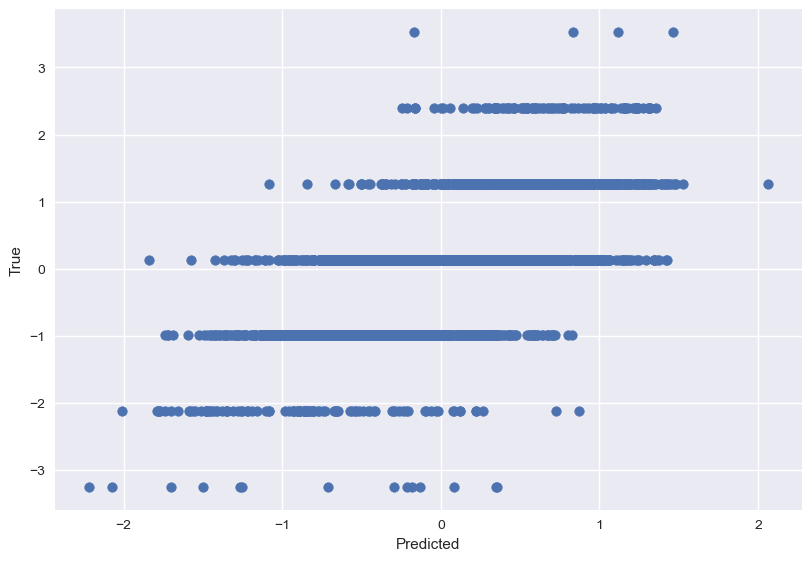

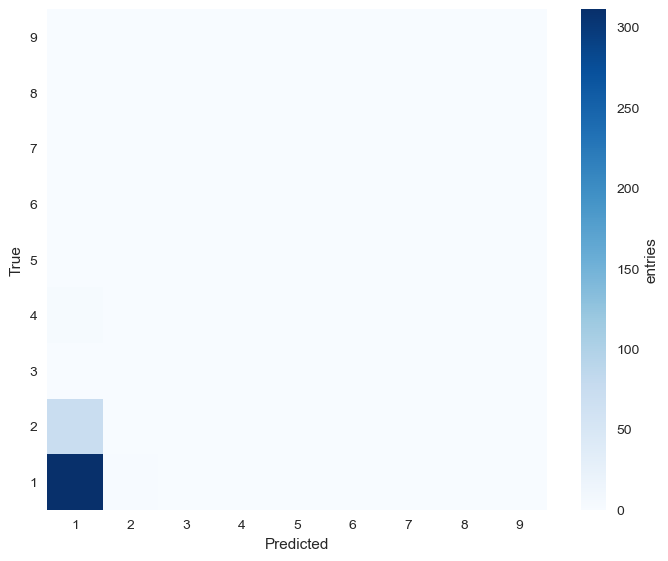

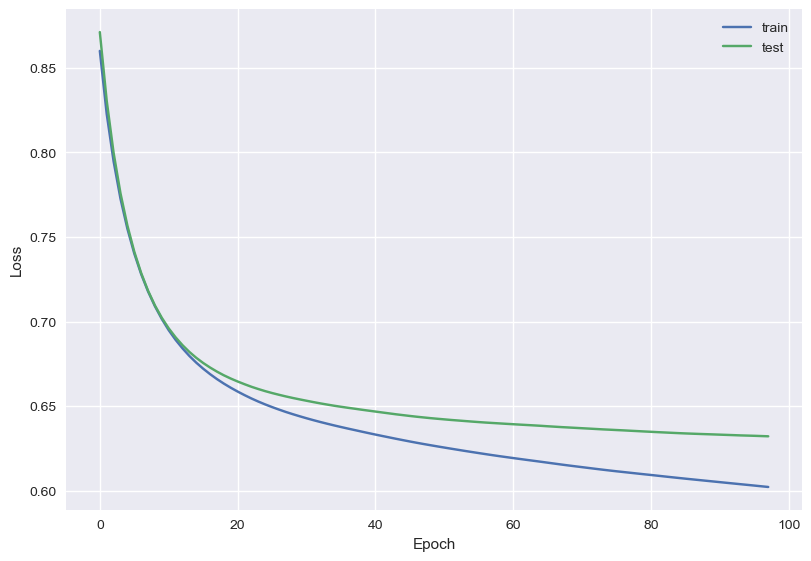

In [10]:
# After the training:

# Prepare scatter plot
y_pred = [dnn(x, W, b, Wp, bp)[0] for x in X_test]

print("Best loss:", min(test_losses), "Final loss:", test_losses[-1])

print("Correlation coefficient:", np.corrcoef(y_pred, y_test)[0, 1])
fig, ax = plt.subplots(layout="constrained")
ax.scatter(y_pred_train, y_train)
ax.set(
    xlabel="Predicted",
    ylabel="True",
)

fig, ax = plt.subplots(layout="constrained")
h = ax.hist2d(
    y_pred_train,
    y_train,
    bins=[np.arange(0.5, 10.5, 1), np.arange(0.5, 10.5, 1)],
    cmap="Blues",
)

ax.set(
    xlabel="Predicted",
    ylabel="True",
    aspect="equal",
)

cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label("entries")


# Prepare and loss over time
fig, ax = plt.subplots(layout="constrained")
ax.plot(train_losses[2:], label="train")
ax.plot(
    test_losses[2:], label="test"
)  # we omit the first data points as the first loss is typically very high which makes it difficult to read the plot.
ax.legend()
ax.set(
    xlabel="Epoch",
    ylabel="Loss",
);

# Hint 1

We want a network with one hidden layer. As activiation in the hidden layer $\sigma$ we apply element-wise ReLu, while no activation is used for the output layer. The forward pass of the network then reads:
$$\hat{y}=\mathbf{W}^{\prime} \sigma(\mathbf{W} \vec{x}+\vec{b})+b^{\prime}$$

# Hint 2

For the regression problem the objective function is the mean squared error between the prediction and the true label $y$:
$$
L=(\hat{y}-y)^{2}
$$

Taking the partial derivatives - and diligently the applying chain rule - with respect to the different objects yields:

$$
\begin{aligned}
\frac{\partial L}{\partial b^{\prime}} &=2(\hat{y}-y) \\
\frac{\partial L}{\partial b_{k}} &=2(\hat{y}-y) \mathbf{W}_{k}^{\prime} \theta\left(\sum_{i} \mathbf{W}_{k i} x_{i}+b_{k}\right) \\
\frac{\partial L}{\partial \mathbf{W}_{k}^{\prime}} &=2(\hat{y}-y) \sigma\left(\sum_{i} \mathbf{W}_{k i} x_{i}+b_{k}\right) \\
\frac{\partial L}{\partial \mathbf{W}_{m k}} &=2(\hat{y}-y) \mathbf{W}_{m}^{\prime} \theta\left(\sum_{i} \mathbf{W}_{m i} x_{i}+b_{m}\right) x_{k}
\end{aligned}
$$

Here, $\Theta$ denotes the Heaviside step function.